## Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import math
pd.options.display.max_columns = 50

In [2]:
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(color_codes=True)

In [3]:
from uszipcode import SearchEngine

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [25]:
def set_labels(freq, ax,horz_shift=.2,vert_shift=1000,w="bold",fsize=10,c="b"):
    '''
    Function
    --------
    Set Frequency Labels on Bar Plot
    
    Parameters
    ----------
    freq : List of frequencies to plot for each bar
    ax : Axis to Plot Frequency Labels on
    horz_shift : Shift labels left/right
    vert_shift : Shift labels up/down
    w : "weight" -> Bold by defauly
    fsize : fontsize
    c : label color
    
    '''
    for i, v in enumerate(freq):
        ax.text(i-horz_shift,v+vert_shift, str(round(v,2)), weight = w,fontsize=fsize,color = c)

In [5]:
def zip_five(df):
    '''
    Function
    --------
        Updates df with a "ZIP_FIVE" column (5 digit zip code)
    
    Parameters
    ----------
        df : Pandas DataFrame with a "ZIP" column
    
    Returns
    -------
        Pandas DataFrame with a ZIP_FIVE column (5 digit zip code)
    '''
    df['ZIP_FIVE'] = df['ZIP'].apply(lambda x: x[:5])
    return df

In [6]:
def find_same_zip(df, zip_code):
    '''
    Function
    --------
        Looks through Database and returns Entries with same zip code
    
    Parameters
    ----------
        df : Pandas DataFrame of Charities
        zip_code : Zip Code to Match on
    
    Returns
    -------
        Pandas DataFrame with Entries matching provided zip code
    '''
    zip_code = str(zip_code)
    
    temp_df = df[df['ZIP_FIVE'] == zip_code]
    temp_df_two = df[df['ZIP'] == zip_code]
    temp_df = pd.concat((temp_df,temp_df_two))
    
    return temp_df

In [7]:
def find_major_category(df,category:str):
    '''
    Function
    --------
        Filter a Pandas DataFrame by an NTEE Major Category
    
    Parameters
    ----------
        df : Pandas DataFrame with 'NTEE_Major_Category' column
        category : NTEE Category to Filter
    
    Return
    ------
        Filtered Pandas DataFrame
    '''
    temp_df = df[df['NTEE_Major_Category']==category]
    
    return temp_df

In [8]:
def search_by_zip_and_major_category(df, zipcode, category):
    '''
    Function
    --------
        Filter a Pandas DataFrame by Zip Code and NTEE Major Category
    
    Parameters
    ----------
        df : Pandas DataFrame with 'NTEE_Major_Category' column
        zipcode : Zipcode to Filter on
        category : NTEE Major Category to Filter on
    
    Return
    ------
        Filtered Pandas DataFrame
    '''
    
    temp_df = find_same_zip(df,zipcode)
    temp_df = find_major_category(temp_df,category)
    
    return temp_df

In [9]:
def find_minor_category(df,category:str):
    '''
    Function
    --------
        Filter a Pandas DataFrame by an NTEE Major Category
    
    Parameters
    ----------
        df : Pandas DataFrame with 'NTEE_Major_Category' column
        category : NTEE Category to Filter
    
    Return
    ------
        Filtered Pandas DataFrame
    '''
    temp_df = df[df['NTEE_Minor_Category']==category]
    
    return temp_df

In [10]:
def search_by_zip_and_minor_category(df, zipcode, category):
    '''
    Function
    --------
        Filter a Pandas DataFrame by zipcode and NTEE Minor Category
    
    Parameters
    ----------
        df : Pandas DataFrame with 'NTEE_Major_Category' column
        zipcode : Zipcode to Filter on
        category : NTEE Minor Category to Filter
    
    Return
    ------
        Filtered Pandas DataFrame    
    '''
    temp_df = find_same_zip(df,zipcode)
    temp_df = find_minor_category(temp_df,category)
    
    return temp_df

In [11]:
def find_zip_state(df,zipcode):
    '''
    Function
    --------
        Looks through DataFrame and returns Entries with same state
    
    Parameters
    ----------
        df : Pandas DataFrame of Charities
        zip_code : Zip Code to Match on
    
    Returns
    -------
        Pandas DataFrame with Entries matching provided state
    '''
    search = SearchEngine(simple_zipcode=True)
    state = search.by_zipcode(zipcode).state
    temp_df = df[df['STATE']==state]
    
    return temp_df

In [12]:
def search_zip_to_state_major_category(df, zipcode, category):
    '''
    Function
    --------
        Filter a Pandas DataFrame by Zip Code and NTEE Major Category
    
    Parameters
    ----------
        df : Pandas DataFrame with 'NTEE_Major_Category' column
        zipcode : Zipcode to Filter on
        category : NTEE Major Category to Filter on
    
    Return
    ------
        Filtered Pandas DataFrame
    '''
    temp_df = find_zip_state(df,zipcode)
    temp_df = find_major_category(temp_df,category)
    
    return temp_df

In [13]:
def add_score_and_sort_df(df,zipcode,zip_factor = 1,county_factor = 1,state_factor=1,top_char=3):
    '''
    Function
    --------
        ADD score column to Pandas DataFrame and return top X rated Charities by score
    
    Parameters
    ----------
        df : Pandas DataFrame with 'ZIP_FIVE' column
        zipcode : Zipcode to Filter on
        zip_factor : Weighting Variable for Charities with Same Zip Code
        county_factor : Weighting Variable for Charities with Same Zip Code
        state_factor : Weighting Variable for Charities with Same State
        top_char : Number of "Top" results to return sorted by score descending
    
    Return
    ------
        Filtered Pandas DataFrame
    '''
    search = SearchEngine(simple_zipcode=True)
    
    county = search.by_zipcode(zipcode).county
    state = search.by_zipcode(zipcode).state
    
    df['zip_factor'] = df['ZIP_FIVE'].apply(lambda x: zip_factor if int(x) == zipcode else 0)
    df['county_factor'] = df['County'].apply(lambda x: county_factor if x == county else 0)
    df['state_factor'] = df['STATE'].apply(lambda x: state_factor if x == state else 0)

    df['score'] = (df['INCOME_CD']+1)*(1+df['zip_factor']+df['county_factor']+df['state_factor'])
    
    temp_df = df.sort_values(by='score',ascending=False).head(top_char)
    
    return temp_df

In [14]:
def recommend_charities(df,zipcode,category,num_rec=3):
    '''
    Function
    --------
        Recommends Charities from a Given Pandas DataFrame
        Uses other functions to filter on a category and score each charity
    
    Parameters
    ----------
        df : Pandas DataFrame with 'ZIP_FIVE' and 'NTEE_Major_Category' columns
        zipcode : Zipcode to Filter on
        category : Category to Filter on
        top_char : Number of "Top" results to return sorted by score descending
    
    Return
    ------
        Filtered Pandas DataFrame with "num_rec" recommendations
    '''
    temp_df = find_major_category(df,category)
    
    scored_df = add_score_and_sort_df(temp_df,zipcode,top_char=num_rec)
    
    return scored_df

## Loading Data

In [15]:
charity_df_optimized = pd.read_csv('../data/charity_df_optimized.csv')

In [23]:
charity_df_optimized.head()

,EIN,NAME,STATE,ZIP,INCOME_CD,NTEE_CD,ZIP_FIVE,NTEE_Major_Category,NTEE_Minor_Category,County
0,587764,IGLESIA BETHESDA INC,MA,01852-2348,0,X21,1852,"Religion-Related, Spiritual Development",Protestant,Middlesex County
1,635913,MINISTERIO APOSTOLICO JESUCRISTO ES EL SENOR INC,MA,01840-1242,0,X21,1840,"Religion-Related, Spiritual Development",Protestant,Essex County
2,765634,MERCY CHAPEL INTERNATIONAL,MA,02126-2433,0,X20,2126,"Religion-Related, Spiritual Development",Christian,Suffolk County
3,841363,AGAPE HOUSE OF PRAYER,MA,02126-1527,0,X20,2126,"Religion-Related, Spiritual Development",Christian,Suffolk County
4,852649,BETHANY PRESBYTERIAN CHURCH,MA,02445-7994,0,X20,2445,"Religion-Related, Spiritual Development",Christian,Norfolk County


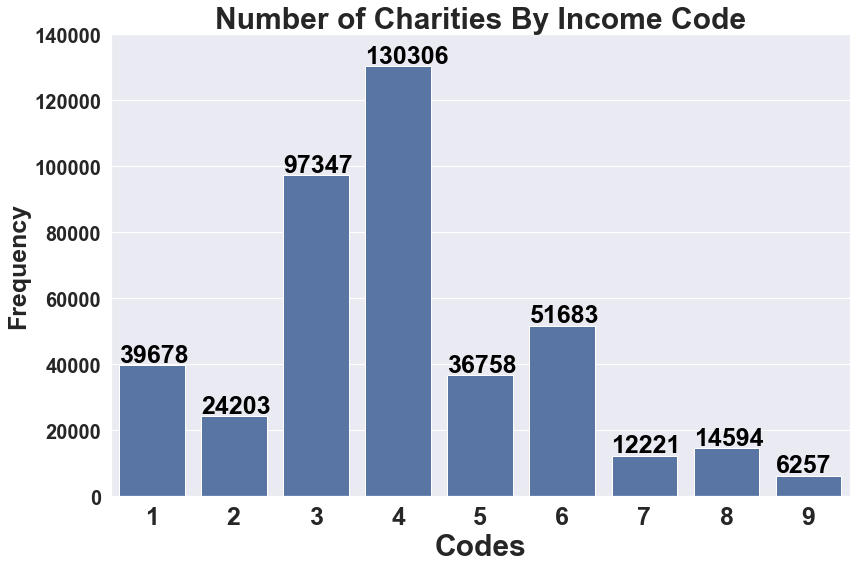

In [45]:
codes_freq = round((charity_df_optimized.groupby('INCOME_CD').size()),1)[1:]
codes = np.arange(1,10)

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=codes,y=codes_freq,color='b')

# Title
ax.set_title(label="Number of Charities By Income Code",weight='bold',fontsize=30)

# X-axis
ax.set_xticklabels(labels=codes,weight='bold',fontsize=25,rotation=0)
ax.set_xlabel(xlabel="Codes",weight='bold',fontsize=30)

# Y-axis
y_tick_nums = np.arange(0,140001,20000)
ax.set_yticks(y_tick_nums)
ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=20)
ax.set_ylabel(ylabel="Frequency",weight='bold',fontsize=25)

# Frequency Labels
set_labels(codes_freq, ax,horz_shift=0.40,vert_shift=1000,w="bold",fsize=25,c="black")

plt.tight_layout()

# plt.savefig('NumCharitiesByIncomeCode.png')

In [94]:
top_3_recs = recommend_charities(charity_df_optimized,48116,'Education')

In [136]:
charity_link = ""
link_list = []
google_links_list = []
count = 1

for i,row in top_3_recs.iterrows():
    charity_link = ''
    google_link = ''
    
    name = str(row.NAME)
    name = name.replace(" ","-")
#     for word in name:
#         charity_link += str(word) + "-"
    charity_link += "https://givz.com/charity/" + name +'-'+str(row.EIN)
    link_list.append(charity_link)
    
    goog_name = name.replace("-","+")
    google_link += 'http://www.google.com/search?q=' + goog_name
    
    google_links_list.append(google_link)
    
google_links_list

['http://www.google.com/search?q=LIVINSTON+CHRISTIAN+SCHOOLS',
 'http://www.google.com/search?q=CLEARY+UNIVERSITY',
 'http://www.google.com/search?q=OPERATING+ENGINEERS+LOCAL+324+JOURNEYMEN+&+APPRENTICE+TRAINING+F']

In [ ]:
http://www.google.com/search?q=Google+tutorial+create+link

In [ ]:
https://www.google.com/search?q=

In [87]:
charity_df_optimized.groupby(by='NTEE_Major_Category').size().sort_values(ascending=False)

NTEE_Major_Category
Religion-Related, Spiritual Development                  150613
Education                                                140807
Human Services - Multipurpose and Other                  113278
Philanthropy, Voluntarism and Grantmaking Foundations     91159
Arts, Culture and Humanities                              90549
Recreation, Sports, Leisure, Athletics                    70233
Youth Development                                         45569
Health - General and Rehabilitative                       37267
Community Improvement, Capacity Building                  30662
Animal-Related                                            29743
Housing, Shelter                                          22937
Environmental Quality, Protection and Beautification      21344
International, Foreign Affairs and National Security      21160
Public, Society Benefit - Multipurpose and Other          18815
Public Safety, Disaster Preparedness and Relief           16830
Mental Health, Crisi

In [60]:
recommend_charities(charity_df_optimized,95060,'Arts, Culture and Humanities')

/Users/jackvessa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jackvessa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jackvessa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,EIN,NAME,STATE,ZIP,INCOME_CD,NTEE_CD,ZIP_FIVE,NTEE_Major_Category,NTEE_Minor_Category,County,zip_factor,county_factor,state_factor,score
734817,510159252,KUUMBWA JAZZ SOCIETY,CA,95060-0000,6,A6C0,95060,"Arts, Culture and Humanities","Music Groups, Bands, Ensembles",Santa Cruz County,1,1,1,28
974536,942600140,ARTS COUNCIL SANTA CRUZ COUNTY,CA,95060-1709,6,A260,95060,"Arts, Culture and Humanities",Arts Council/Agency,Santa Cruz County,1,1,1,28
1467169,942718861,THE MUSEUM OF ART AND HISTORY AT THE MCPHERSON...,CA,95060-4508,6,A510,95060,"Arts, Culture and Humanities",Art Museums,Santa Cruz County,1,1,1,28


In [90]:
recommend_charities(charity_df_optimized,94040,'Human Services - Multipurpose and Other')

,EIN,NAME,STATE,ZIP,INCOME_CD,NTEE_CD,ZIP_FIVE,NTEE_Major_Category,NTEE_Minor_Category,County,zip_factor,county_factor,state_factor,score
644854,452757586,GOOD VENTURES,CA,94040-1498,9,P11,94040,Human Services - Multipurpose and Other,Single Organization Support,Santa Clara County,1,1,1,40
973836,942295953,UPLIFT FAMILY SERVICES,CA,95008-1940,9,P300,95008,Human Services - Multipurpose and Other,"Children's, Youth Services",Santa Clara County,0,1,1,30
972855,941156318,YOUNG MENS CHRISTIAN ASSOCIATION OF SILICON VA...,CA,95051-7303,9,P27,95051,Human Services - Multipurpose and Other,"Young Men's or Women's Associations (YMCA, YWC...",Santa Clara County,0,1,1,30
